# Application use our Poisson System

In this notebook, you can find brief introduction of how to use our package to realize seamless editing. We also replicate the paper examples using similar pictures to prove the correctness of our algorithms. Finally we test our performance in real life examples and recognize some problem embeded in this algorithm.

In [1]:
from src.util import *
from src.get_mask import Painter
from src.poisson_system import Poisson_system
from src.poisson_solver import sor_solver_jit
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import cv2
hidecode()

## Table of Contents

1. [User Guide](#User-Guide)
1. [Replicate paper example in new dataset](#Replicate-paper-example)
    1. [Seamless Cloning](#Seamless-cloning)
        1. [Import Gradients](#import-gradients)
        2. [Mixing Gradients](#mixing-gradients)
    2. [Selecting Editing](#Selecting-editing)
        1. [Texture Flattening](#Texture-flattening)

# User-Guide

## 1. Get mask
Our algorithm requires a mask to point out the interesting area $\Omega$ in source image $g$ to destination image $f^*$. By creating your painter object from `Painter` class and call function `get_mask()`, you can start to draw your mask in source image $g$ in [draw mask](#draw-mask) window , and drag it into your target position in destination image $f^*$ in [move mask](#region). 

```python
pp = Painter(g_impath, f_impath)  # g_impath: (str) path for source img. f_impath: (str) path for destination img.
pp.get_mask(maskname='mask.png')  # maskname: (str) name to store the mask. If None, then "'gname'_'fname'.png" will be used.
```
### draw-mask
It will pop out an adjustable window for you to draw mask in the source image $g$, with instruction in the window name bar:
- press `p` or `P` to change drawing mode from quick mode to detailed mode:
    - quick mode: click mouse and drag to draw rectangle mask, which covers the whole rectangle regions from your start point to end. This allows you to cover large area inside $\Omega$.
    - detailed mode: click mouse and drag to draw curve, which only covers your mouse moving trace. This allows you to draw detailed edge around the boarder of $\Omega$. Under this mode, you can also adjust the size of the painter:
        - press `L` or `l` to resize the painter to larger pixel size. 
        - press `M` or `m` to resize the painter to smaller pixel size.
- press `S` or `s` to finish drawing and save mask. It will pop up a new window showing your mask, please press any key to continue.
- press `R` or `r` to reset the drawing. You can restart to draw your mask again.
- press `Q` or `q` to discard your drawing and exit without saving the mask.

### move-mask
It will pop out an adjustable window for you to move mask in the destination image $g$, with instruction in the window name bar:
- press `p` or `P` to change moving mode from move mode to resize mode:
    - move mode: simply drag the mask to your desired position
    - resize mode: there is a "resize" tracebar in the top of the window, ranging from $0$ to $20$ and positing at $10$. If you drag the bar to $x$ position, the mask will resize to its $x/10$ times original size by a similar transformation. In another words, $0-9$ is smaller the mask, $11-20$ is larger the mask. 
- press `S` or `s` to finish moving and save mask. It will pop up a new window showing your mask, please press any key to continue.
- press `R` or `r` to reset the shifting. You can restart to move your mask again.
- press `Q` or `q` to discard your shifting and exit without saving the mask.

Notes: do not move your mask outside the window, otherwise it will truncate the mask and only keep the visible region as mask area, unless this is what you want. When resize the mask to bigger one, remember to move it to top left area first to avoid it jump outside the window.

## 2. Construct Poisson System
With the source image $g$, destination image $f^*$, and mask array $M$, you can construct your Poisson_system object and achieve different image editing method as you want.

```python
# adjust_ilu: wether or not to adjust illuminance of destination and source image. This is the main issue of Poisson algorithm, and here we proposed a naive way to solve it.
# alpha: range from 0-1. If the adjust_ilu is True, alpha is the percentage of illuminance from source image. If alpha=1, change the border area of destination image f to have the same illuminance as source image in mask area. If alpha=0. unchange. If alpha in between, the illuminance of border area of destination image will have an illuminance level in between.
PS = Poisson_system(source=source, destination=destination, mask=mask,adjust_ilu=adjust_ilu,alpha=alpha)
A, b = PS.get_Ab(method=method) 
```
Available methods are as follows.

In [2]:
Poisson_system.method_list

[['dg', 'import gradients', 'basic seamless cloning'],
 ['dgf', 'mixing gradients', 'transparent seamless cloning'],
 ['Mdg', 'masked gradients', 'texture flattening'],
 ['ilm', 'illumination', 'change local ilumination']]

### 3. Solve Poisson Equation
Solving the poisson equation $Af=b$ will give a smooth results $f$ in $\Omega$ area. Using `PS.combine` will render final image. You can choose to use our own `poisson_solver.sor_solver_jit`, or use `scipy.sparse.linalg.spsolve`, They will get the same results.
```python
# use our own solver
data = [np.array(it) for it in A.data]
rows = [np.array(it) for it in A.rows]
diag = A.diagonal()
x1 = sor_solver_jit(data, rows, diag, b, omega=1.8, x0=np.zeros_like(b),eps=1e-3)
# use scipy solver
x1 = spsolve(A=A, b=b)

# get final image
final_img = PS.combine(x1)
```

For better usage, we wrap the above codes in the `seamless_blending` function. One can use one-line code to finish seamless blending:
```python
final_img, PS = seamless_blending(paths, gname,fname, method='dg', maskname=None,fname=fname,draw=True,adjust_ilu=False, alpha=0.5, set_monochrome=None)
# if set_monochrome='g', then source image will be set to monochrome beforehand; if 'f', then the destination image will be changed. If None, then skip this step.
```

In [3]:
def seamless_blending(paths, gname, fname, method='dg', maskname=None,omega=1.8, show_plot=True, draw=True, 
                      adjust_ilu=False, alpha=0.5, set_monochrome=None,**args):
    maskname = gname.split('.')[0]+'_'+fname.split('.')[0]+'.png' if maskname is None else maskname
    if draw:
        # draw mask
        pp = Painter(g_impath=paths+gname, f_impath=paths+fname)
        pp.get_mask(maskname)
        source = cv2.cvtColor(pp.g, cv2.COLOR_BGR2RGB)
        destination = cv2.cvtColor(pp.f, cv2.COLOR_BGR2RGB)
        mask = pp.mask
    else:
        source = plt.imread(paths+'new_'+gname)
        destination = plt.imread(paths+fname)
        mask = plt.imread(paths+maskname)
    
    # set monochrom before hand
    if set_monochrome=='g':
        source = cv2.cvtColor(source, cv2.COLOR_RGB2GRAY)
        source = np.repeat(source[:,:,np.newaxis],3,axis=2)
    elif set_monochrome=='f':
        destination = cv2.cvtColor(destination, cv2.COLOR_RGB2GRAY)
        destination = np.repeat(destination[:,:,np.newaxis],3,axis=2)
    
    # get poisson equation
    PS = Poisson_system(source=source, destination=destination, mask=mask,adjust_ilu=adjust_ilu,alpha=alpha)
    A, b = PS.get_Ab(method=method,**args)
    data = [np.array(it) for it in A.data]
    rows = [np.array(it) for it in A.rows]
    diag = A.diagonal()

    # solve poisson equation
    #x0 = PS.g[PS.mask==1]
    #x1 = sor_solver_jit(data, rows, diag, b, omega, x0=x0,eps=5e-3)
    x1 = spsolve(A=A, b=b)
    combinel_img = PS.combine(x1)
    
    # show plot
    if show_plot:
        sourcetmp = blend(source, mask, x=np.ones_like(source) * 255, alpha=0.7)
        plt.figure(figsize=(10, 8))
        plt.subplot(2, 2, 1)
        plt.imshow(sourcetmp)
        plt.title('source')
        plt.subplot(2, 2, 2)
        plt.imshow(destination)
        plt.title('destination')
        plt.subplot(2,2,3)
        plt.imshow(blend(image=destination,mask=mask,x=source,alpha=0))
        plt.title('normal blending')
        plt.subplot(2,2,4)
        plt.imshow(combinel_img)
        plt.title('Seamless blending: '+PS.cur_method[1])
        plt.tight_layout()
        plt.savefig(paths+maskname.split('.')[0]+'.jpg')
        plt.show()
    return combinel_img,PS

# Replicate-paper-example
## Seamless-cloning
### import-gradients


**Figure 2: Concealment.** Using the same image for source and destination, we can hidden undesirable parts by seamless importing the similar parts from original picture and repeats for several time.

To repeat the process, let `draw=False`. If you want to draw your new version, let `draw=True`.

In [4]:
paths = './data/paper_example/'
draw=False

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


D:\Program\Anaconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


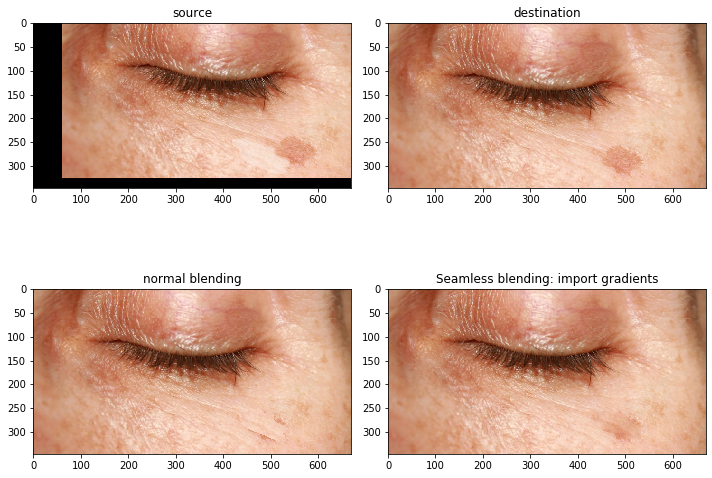

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


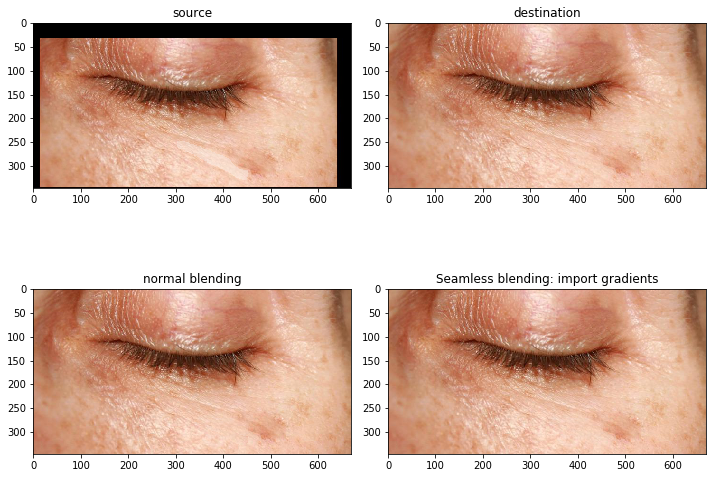

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


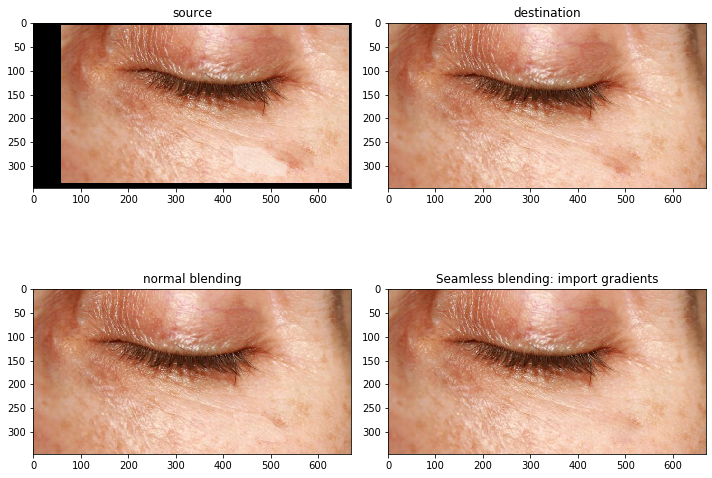

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


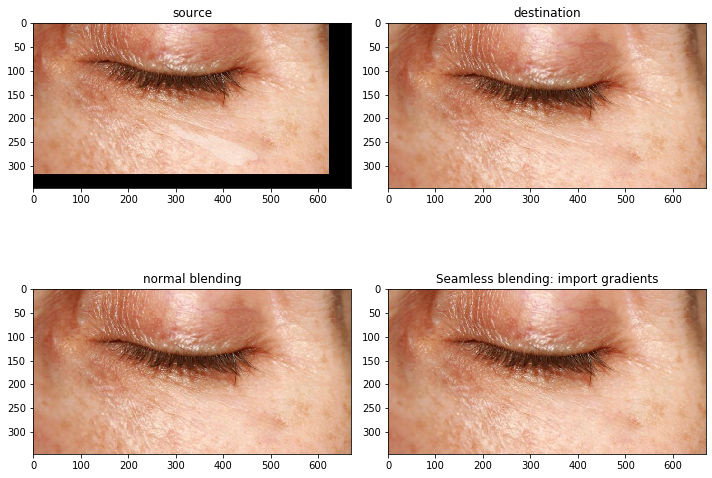

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


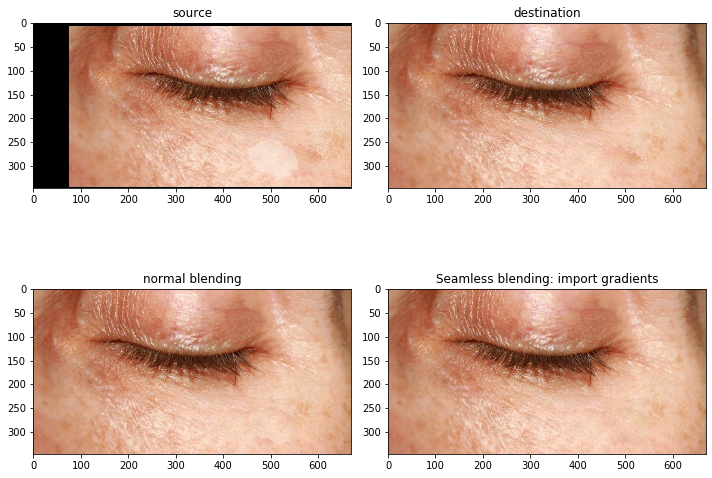

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


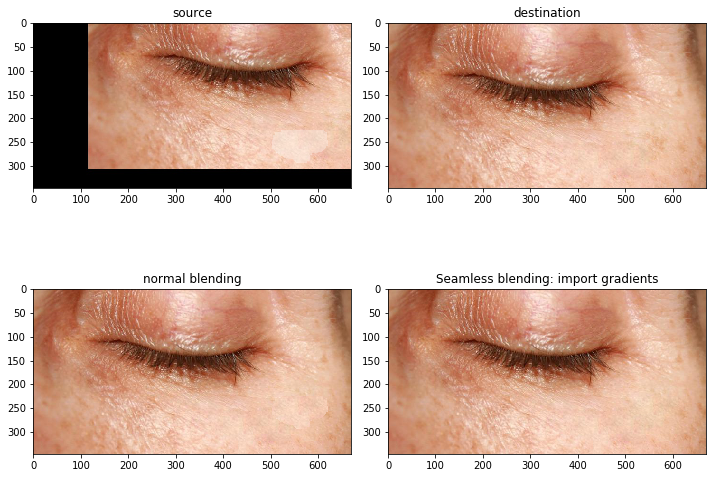

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


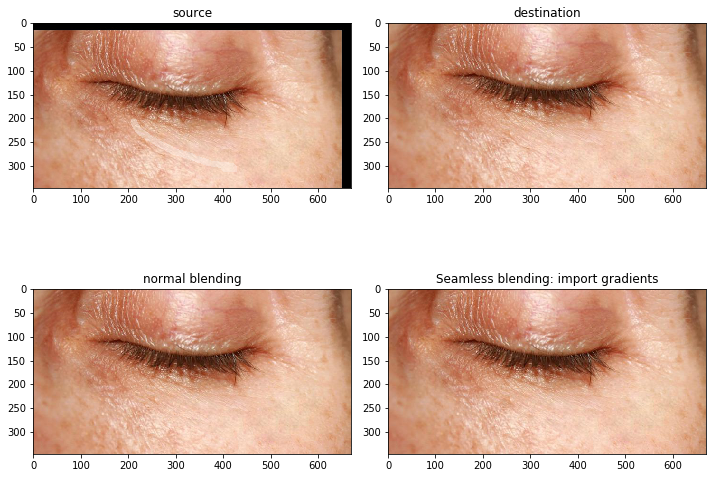

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


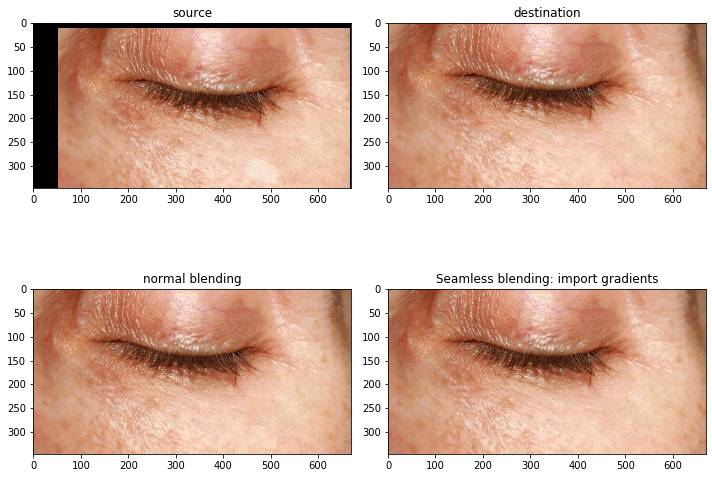

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


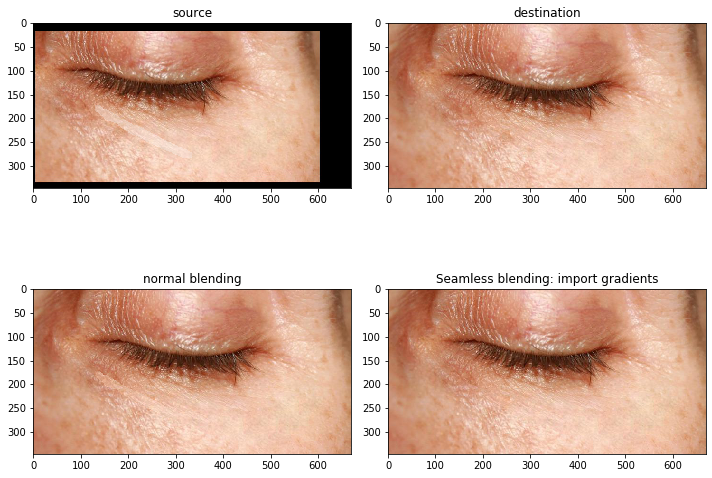

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


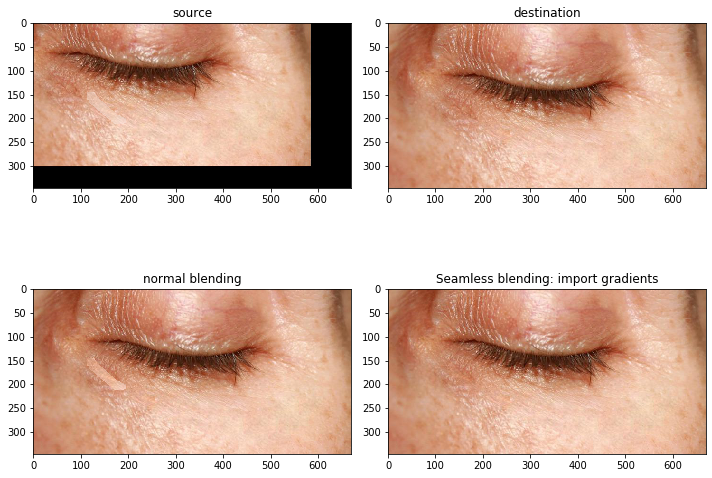

In [4]:
for i in range(10):
    final_img, PS = seamless_blending(paths=paths, gname='old_spots{}.jpg'.format(i),fname='old_spots{}.jpg'.format(i),maskname='old_spots_mask{}.png'.format(i),draw=draw)
    plt.imsave(paths+'old_spots{}.jpg'.format(i+1),final_img)

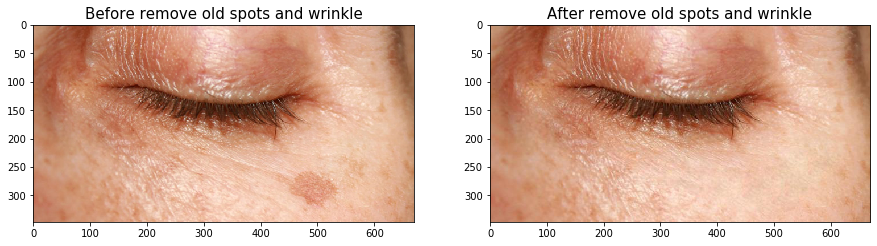

In [4]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(plt.imread(paths+'old_spots0.jpg'))
plt.title('Before remove old spots and wrinkle',fontsize=15)
plt.subplot(1,2,2)
plt.imshow(plt.imread(paths+'old_spots9.jpg'))
plt.title('After remove old spots and wrinkle',fontsize=15)
plt.show()
plt.saveimage(paths+'results/old_spots9.jpg',plt.imread(paths+'old_spots9.jpg'))

**Figure 3: Insertion**.  Seamless insertion can keep local material in the destination image.

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


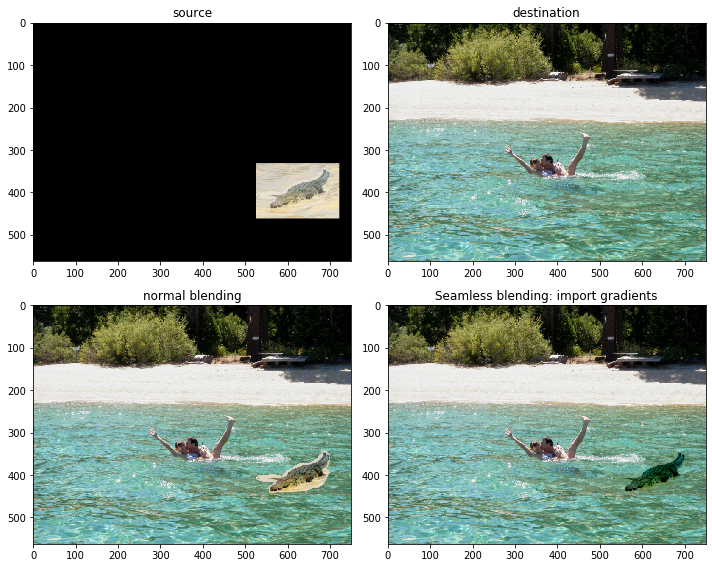

In [18]:
final_img, PS = seamless_blending(paths=paths, gname='crocodile.jpg',fname='swim.jpg',draw=draw, adjust_ilu=True, alpha=0.5)
plt.imsave(paths+'results/'+'crocodile_swim.jpg',final_img)

resize 0.8
resize 1.0
save mask in./data/paper_example\moon_light_lake.png
save new g in./data/paper_example\new_moon_light.jpg
Import gradient ['dg', 'import gradients', 'basic seamless cloning']


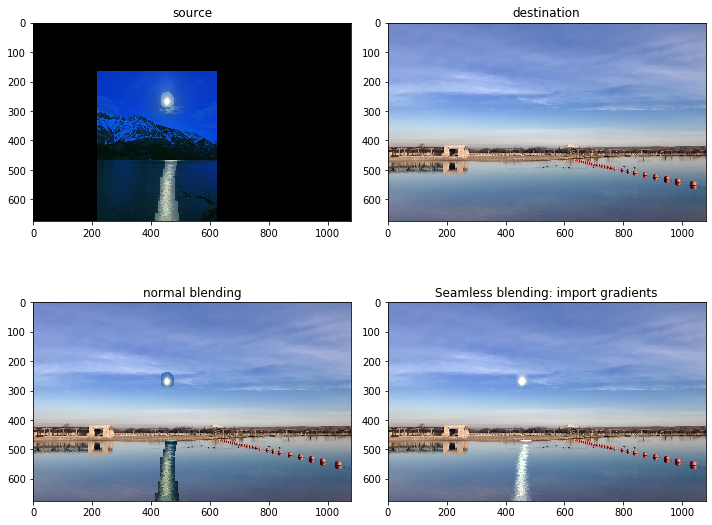

In [8]:
final_img, PS = seamless_blending(paths=paths, gname='moon_light.jpg',fname='lake.jpg',draw=draw)
plt.imsave(paths+'results/'+'moonlight_lake.jpg',final_img)

**Figure 4: Feature Exchange** We can seamlessly replace once face into another.

resize 0.9
resize 1.0
resize 0.8
resize 1.0
resize 0.7
resize 1.0
save mask in./data/paper_example\me_cql0.png
save new g in./data/paper_example\new_me.jpg
Import gradient ['dg', 'import gradients', 'basic seamless cloning']


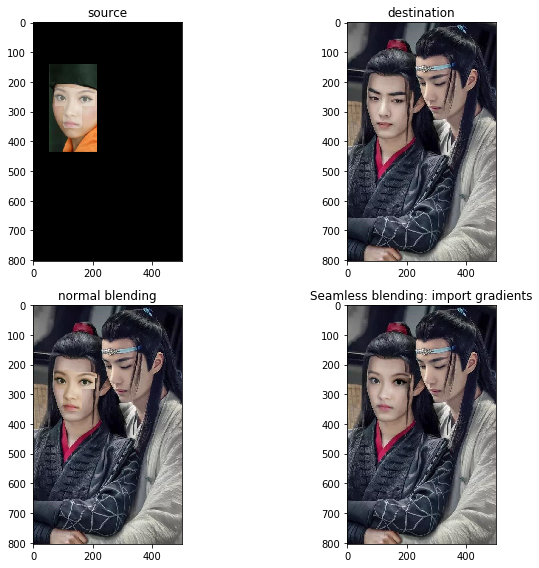

save mask in./data/paper_example\cql0_me_cql.png
save new g in./data/paper_example\new_cql0.jpeg
Import gradient ['dg', 'import gradients', 'basic seamless cloning']


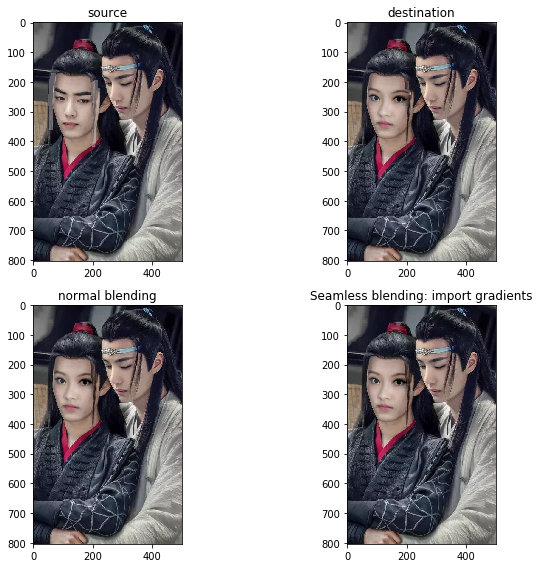

In [23]:
final_img, PS = seamless_blending(paths=paths, gname='me.jpg',fname='cql0.jpeg',draw=draw)
plt.imsave(paths+'me_cql.jpg',final_img)
final_img, PS = seamless_blending(paths=paths, gname='cql0.jpeg',fname='me_cql.jpg',draw=draw)
plt.imsave(paths+'me_cql1.jpg',final_img)

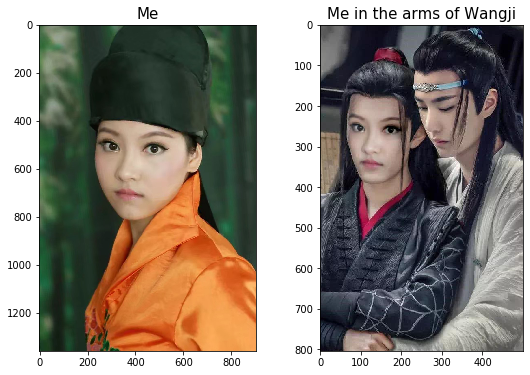

In [25]:
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.imshow(plt.imread(paths+'me.jpg'))
plt.title('Me',fontsize=15)
plt.subplot(1,2,2)
plt.imshow(plt.imread(paths+'me_cql1.jpg'))
plt.title('Me in the arms of Wangji',fontsize=15)
plt.show()
plt.imsave(paths+'results/me_cql1.jpg',plt.imread(paths+'me_cql1.jpg'))

**Figure 5: Monochrome transfer.** Transfer texture without color can be achieved by setting source image monochrome beforehand.

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


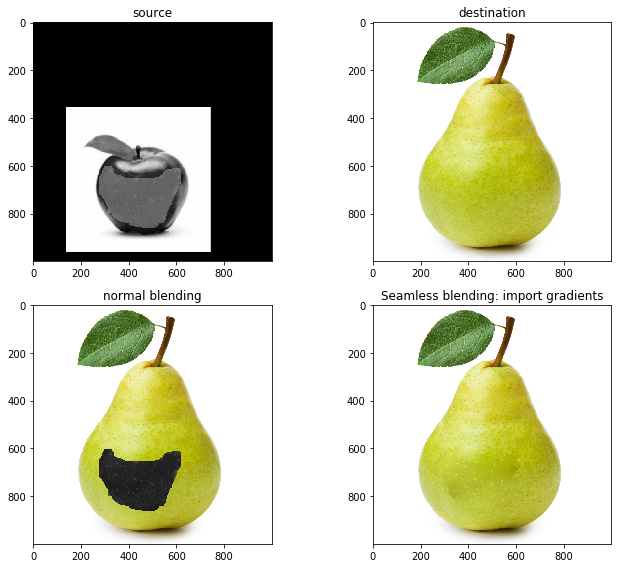

In [13]:
final_img,PS = seamless_blending(paths,gname='apple.jpg', fname='pear.jpg',method='dg',draw=draw, adjust_ilu=False, set_monochrome='g')
plt.imsave(paths+'results/'+'apple_pear.jpg',final_img)

### mixing-gradients

**Figure 6: Inserting objects with holes** Use mixing gradient we can realize transparent and hole editing.

mixing gradient ['dgf', 'mixing gradients', 'transparent seamless cloning']


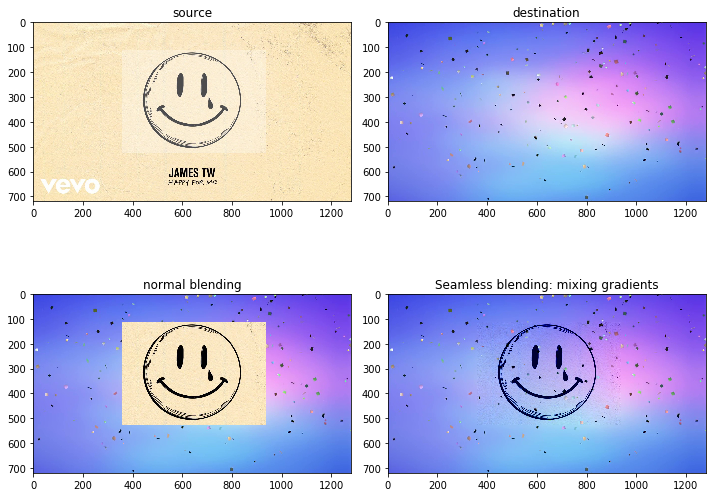

In [14]:
final_img,PS = seamless_blending(paths,gname='happy.jpg', fname='background.jpg',method='dgf',draw=draw)
plt.imsave(paths+'results/'+'happy_background.jpg',final_img)

**Figure 7: Inserting transparant objects**. Mixed seamless cloning facilitates the transfer of partly transparent objects.

resize 0.6
resize 1.0
resize 0.6
resize 1.0
resize 0.6
resize 1.0
resize 0.6
resize 1.0
resize 0.9
resize 1.0
resize 0.8
resize 1.0
save mask in./data/paper_example\rainbow_harvard.png
save new g in./data/paper_example\new_rainbow.png
mixing gradient ['dgf', 'mixing gradients', 'transparent seamless cloning']


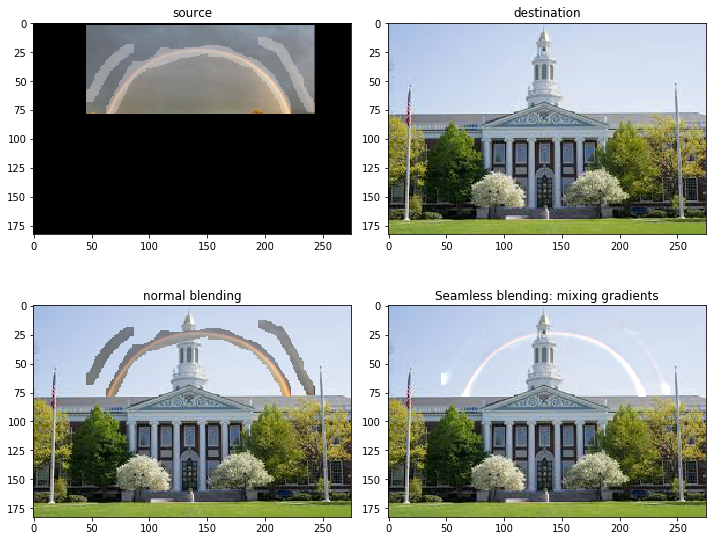

In [17]:
final_img,PS = seamless_blending(paths,gname='rainbow.png', fname='harvard.jpg',method='dgf',draw=True)
plt.imsave(paths+'results/'+'rainbow_harvard.jpg',final_img)

## Selecting-editing
### Texture-flattening
By applying a edge detector mask over the gradient field, we can realize in-place image editing

In [9]:
final_img,PS = seamless_blending(paths,gname='kyt.jpg', fname='kyt.jpg',method='Mdg',draw=True,low=100,high=300)
plt.imsave(paths+'results/'+'kyt_flatten.jpg',final_img)

save mask in./data/paper_example\kyt_kyt.png
save new g in./data/paper_example\new_kyt.jpg
masked gradient ['Mdg', 'masked gradients', 'texture flattening']
300 100


MemoryError: Unable to allocate array with shape (1335, 2000, 3) and data type uint8

## Object Insertion
### 1. Seamless insert people into their idol’s picture

Import gradient ['dg', 'import gradients', 'basic seamless cloning']


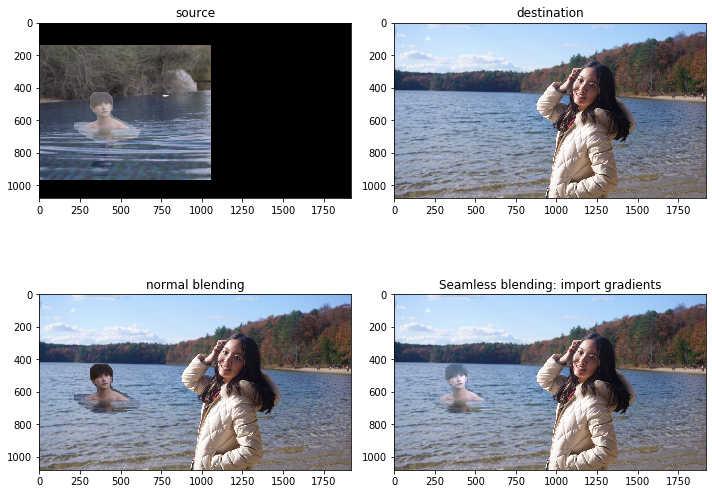

In [11]:
paths = './data/'
final_img,PS = seamless_blending(paths,gname='yyyy1.jpg', fname='kytlake.jpg',method='dg',draw=draw, adjust_ilu=True, alpha=0.3)

In [44]:
PS.map.bnd.shape

(1080, 1919)

In [47]:
PS.f[PS.map.bnd==1].mean()

160.9418377321603

In [48]:
PS.g[PS.mask==1].mean()

101.8853433862267

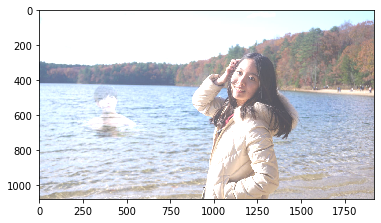

In [53]:
# fill_color = blend(final_img, cv2.erode(PS.mask, PS.kernel,iterations=5), PS.g, alpha=0.5)
fill_color = final_img.copy()
fill_color=np.clip(fill_color+0.3,0,1)
plt.imshow(fill_color)
# plt.imsave(paths+'/result/kyt_bjt_fill.jpg',fill_color)

In [63]:
fill_color.mean(0).shape

(1919, 3)

In [8]:
PS.g.max()

255.0

In [21]:
PS.mask.shape

(900, 1440)